#  <center> Data Science 100 Group Project <center>
## <center> Predicting Heart Disease Presence <center>

## Introduction

## Data Analysis

In [1]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
## load packages
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
## read data and mutate response variable to be a factor
url <- "https://raw.githubusercontent.com/Kyleetd/DSCI100-Course-Project-2023/main/heart_disease.csv"

heart_disease_data <- read_csv(url) |>
  rename(
    'heart_stroke' = 'Heart_ stroke') |>
 mutate(heart_stroke = factor(heart_stroke,levels = c("yes", "No"),labels = c("yes", "no"))) 

head(heart_disease_data)

Rows: 4238 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Gender, education, prevalentStroke, Heart_ stroke
dbl (12): age, currentSmoker, cigsPerDay, BPMeds, prevalentHyp, diabetes, to...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,heart_stroke
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,39,postgraduate,0,0,0,no,0,0,195,106.0,70,26.97,80,77,no
0,46,primaryschool,0,0,0,no,0,0,250,121.0,81,28.73,95,76,no
1,48,uneducated,1,20,0,no,0,0,245,127.5,80,25.34,75,70,no
1,61,graduate,1,30,0,no,1,0,225,150.0,95,28.58,65,103,yes
1,46,graduate,1,23,0,no,0,0,285,130.0,84,23.10,85,85,no
0,43,primaryschool,0,0,0,no,1,0,228,180.0,110,30.30,77,99,no


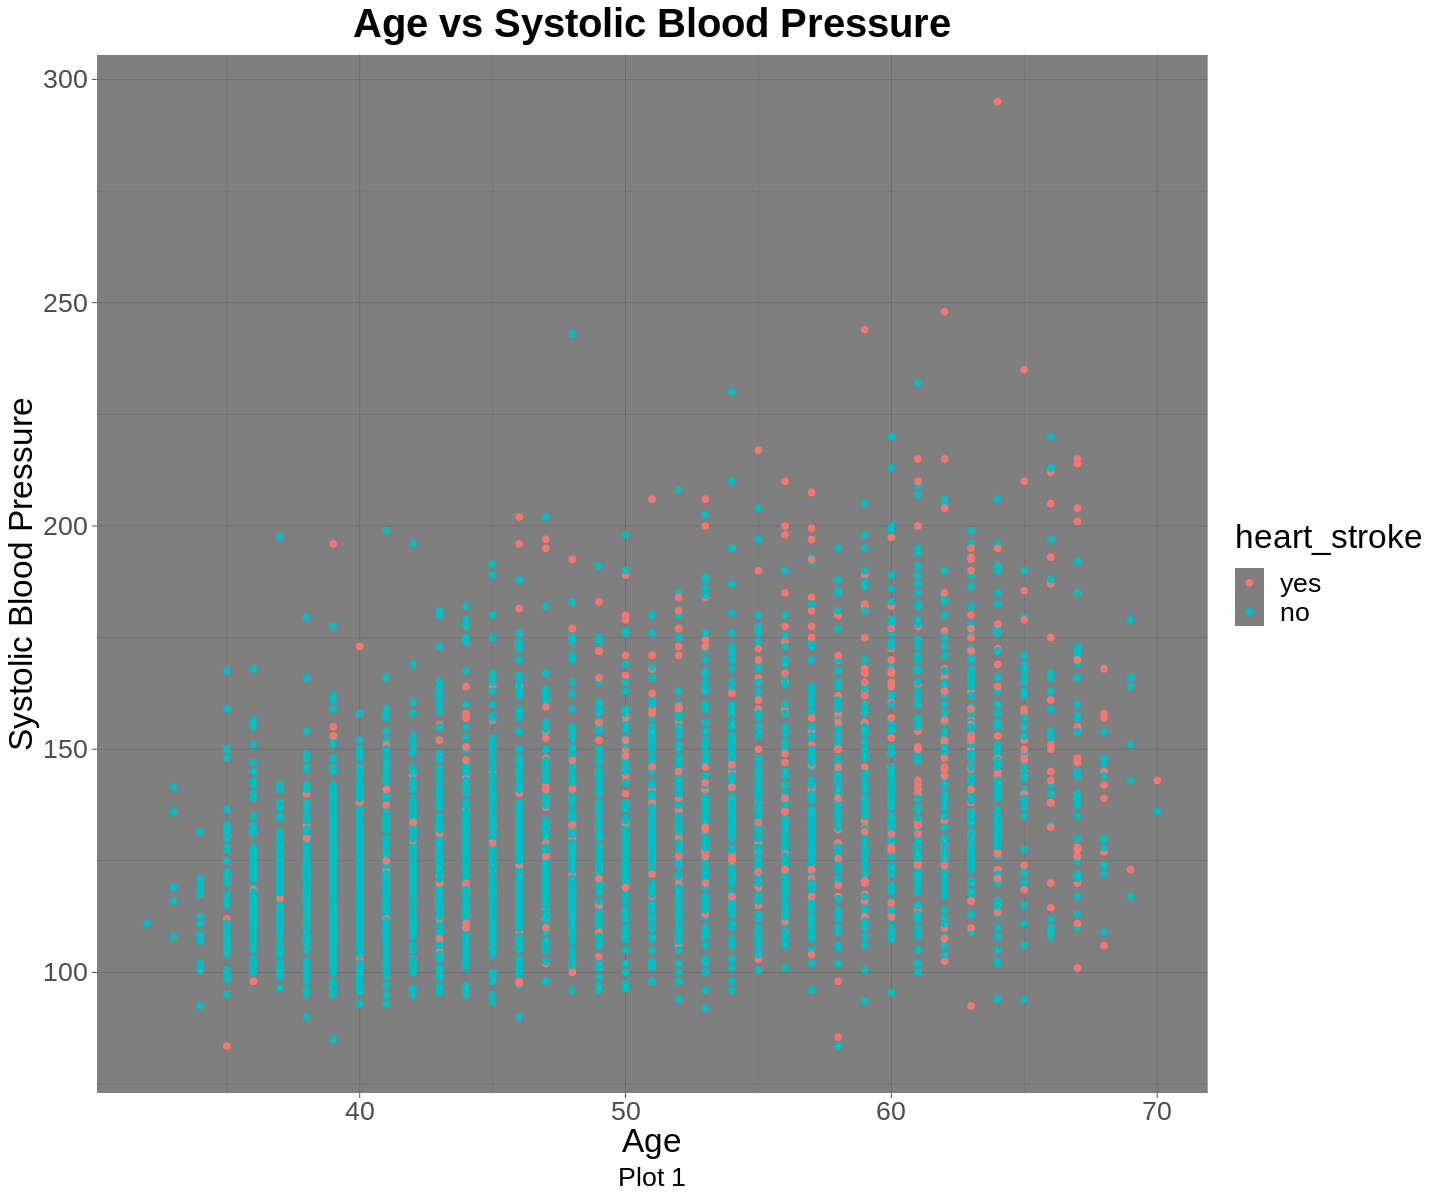

In [4]:
## Filter data so there's no N/A observations in the predictor variables
heart_disease_filtered <- filter(heart_disease_data, heart_stroke != "NA", age != "NA", sysBP != "NA") 

options(repr.plot.width=12, repr.plot.height=10)
plot <- ggplot(heart_disease_filtered, aes(x = age, y = sysBP, color = heart_stroke)) +
  geom_point() +
  labs(x = "Age", 
       y = "Systolic Blood Pressure", 
       title = "Age vs Systolic Blood Pressure", 
       caption = "Plot 1") +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

plot

In [5]:
## establish training and testing data sets
set.seed(5)
heart_disease_split <- initial_split(heart_disease_filtered, prop = 0.75, strata = heart_stroke)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

### Calibrating Parameter K

In [6]:
## Create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_recipe <- recipe(heart_stroke ~ age + sysBP, data = heart_disease_train) |>
   step_upsample(heart_stroke, over_ratio = 1, skip = FALSE) |>
   prep() 

heart_disease_train_balanced <- bake(heart_recipe, heart_disease_train)

heart_recipe_balanced <- recipe(heart_stroke ~ age + sysBP, data = heart_disease_train_balanced) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

head(heart_disease_train_balanced)

age,sysBP,heart_stroke
<dbl>,<dbl>,<fct>
58,129,yes
52,126,yes
41,141,yes
52,148,yes
67,155,yes
42,118,yes


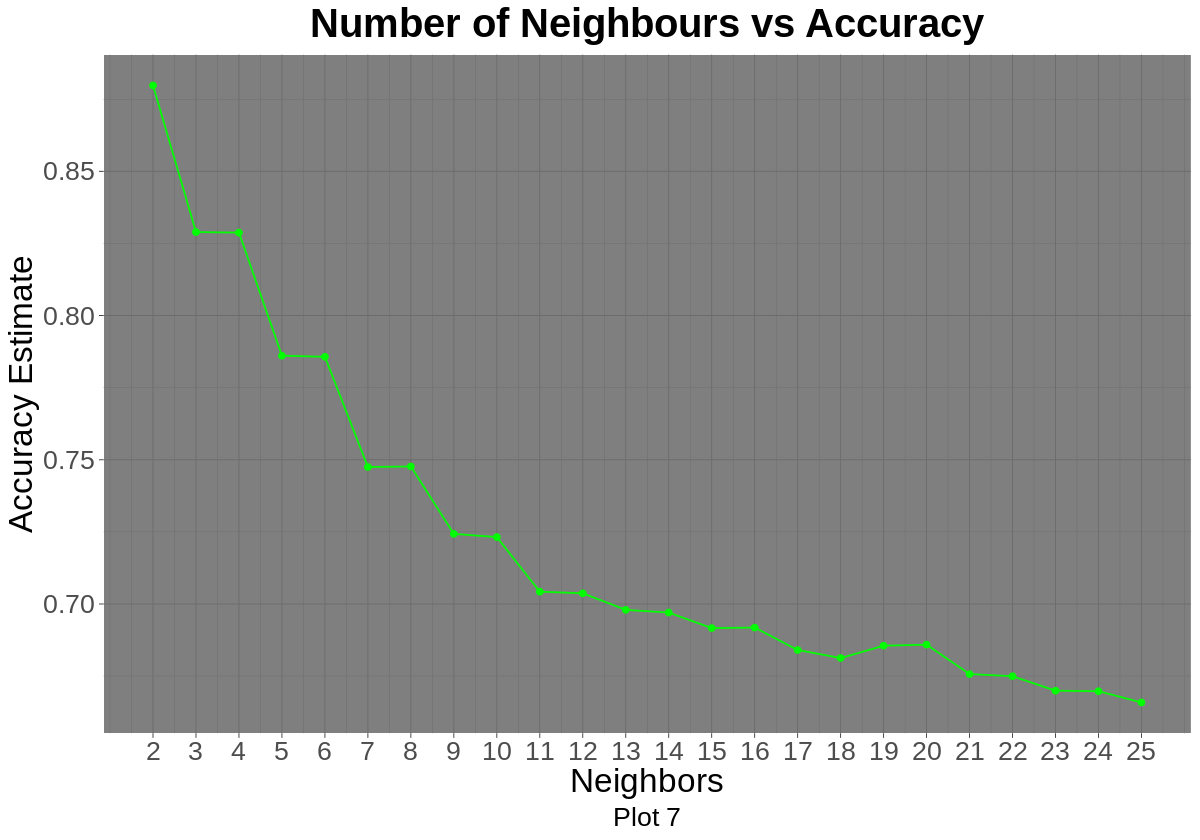

In [7]:
# Cross validation
heart_vfold <- vfold_cv(heart_disease_train_balanced, v = 10, strata = heart_stroke)

## k values to try
k_vals <- tibble(neighbors = seq(from = 2, to = 25, by = 1))

## Create a workflow & get accuracy metrics
heart_accuracies <- workflow() |>
      add_recipe(heart_recipe_balanced) |>
      add_model(knn_spec) |>
      tune_grid(resamples = heart_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

## Plot the 𝑘 vs the accuracy
options(repr.plot.width=10, repr.plot.height=7)
cross_val_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean)) +
  geom_point(color = "green") +
  geom_line(color = "green") +
  labs(x = "Neighbors", 
       y = "Accuracy Estimate", 
       title = "Number of Neighbours vs Accuracy", 
       caption = "Plot 7") +
  scale_x_continuous(breaks = round(seq(min(heart_accuracies$neighbors), max(heart_accuracies$neighbors), by = 1),1)) +
  theme_dark() +
  theme(text = element_text(size = 20), plot.title = element_text(face = "bold", hjust = 0.5), plot.caption = element_text(hjust = 0.5))

cross_val_plot

In [8]:
## Select highest accuracy k
k <- heart_accuracies |>
    arrange(-mean) |>
    slice(1) |>
    pull(neighbors)
k 

[1] 2

### Conducting Classification with Highest Accuracy K

In [ ]:
## New model specification
knn_refined_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
      set_engine("kknn") |>
      set_mode("classification")

## New workflow 
heart_fit <- workflow() |>
      add_recipe(heart_recipe_balanced) |>
      add_model(knn_spec) |>
      fit(data = heart_disease_train_balanced)

Warning message:
“tune samples were requested but there were 5390 rows in the data. 5385 will be used.”


#### Predict 

In [ ]:
set.seed(9999) 

## predict on the test dataset using refined model
predictions <- predict(heart_fit, heart_disease_test) |>
      bind_cols(heart_disease_test) ## add prediction column to testing_set dataframe 

## accuracy of this prediction
metrics <- predictions |>
  metrics(truth = heart_stroke, estimate = .pred_class)

## confusion matrix
conf_mat <- predictions |> 
    conf_mat(truth = heart_stroke, estimate = .pred_class)

conf_mat
metrics